# Test filter on synthetic IBL data

In [53]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import default_rng
from scipy.special import logit

In [33]:
rng = default_rng(999)

## Create synthetic IBL data

In [34]:
def gen_trials(n_smps, rng, hazard_rate=0.1, p_right=[0.2, 0.8], c_vals=[12, 25, 50, 100], b_init=0):
   
    block = b_init
    
    for i in range(n_smps):
        
        # Sample side (L=-1, R=1) using probability for current block value
        side = 1 - 2 * rng.binomial(1, p_right[block])
        
        # Sample contrast uniformly from c_vals, with sign determined by side
        signed_contrast = side * rng.choice(c_vals) 
        
        yield (block, side, signed_contrast)
        
        # Switch blocks with Probability equal to hazard rate
        if rng.binomial(1, hazard_rate):
            block = 1 - block

In [56]:
n_trials = 100
hazard_rate = 0.1
alpha = 0.2

trials = list(gen_trials(n_trials, rng, hazard_rate=hazard_rate, p_right=[alpha, 1 - alpha]))

b_smps = np.array([t[0] for t in trials])
s_smps = np.array([t[1] for t in trials])
x_smps = np.array([t[2] for t in trials])

Text(0, 0.5, 'signed contrast')

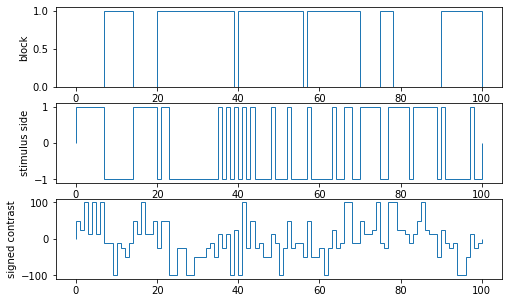

In [57]:
(fig, ax) = plt.subplots(3, 1, figsize=(8, 5))

ax[0].stairs(b_smps)
ax[0].set_ylabel('block')

ax[1].stairs(s_smps)
ax[1].set_ylabel('stimulus side')

ax[2].stairs(x_smps)
ax[2].set_ylabel('signed contrast')

## Use filter to infer block from stimulus side

In [77]:
def phi(x, c):
    return np.log(np.exp(c + x) + 1) - np.log(np.exp(c) + np.exp(x)) 

def block_LP(r_prev, hazard_rate):
    return phi(r_prev, logit(1 - hazard_rate))

def block_LL(side, alpha):
    return side * logit(alpha)

def side_LP(r_prev, hazard_rate, alpha):
    return phi(r_prev, logit(alpha + hazard_rate - 2 * alpha * hazard_rate))

def side_LL(signed_contrast, w):
    return w * signed_contrast

In [78]:
b_lik = np.full(n_trials, np.nan)
b_prior = np.full(n_trials, np.nan)
b_filter = np.full(n_trials, np.nan)

s_lik = np.full(n_trials, np.nan)
s_prior = np.full(n_trials, np.nan)
s_filter = np.full(n_trials, np.nan)

# Set first log-prior term to zero
b_prior[0] = 0;

for t in range(n_trials):
    
    # Compute log-likelihood of observed stimulus side
    b_lik[t] = block_LL(s_smps[t], alpha)
    
    # Update filter
    b_filter[t] = b_lik[t] + b_prior[t]
    
    # Update log-prior for next time step
    if t < n_trials - 1:
        b_prior[t + 1] = block_LP(b_filter[t], hazard_rate)

In [89]:
filter_est = (np.sign(b_filter) + 1) / 2
filter_err = (b_smps - filter_est) ** 2

### Filter results

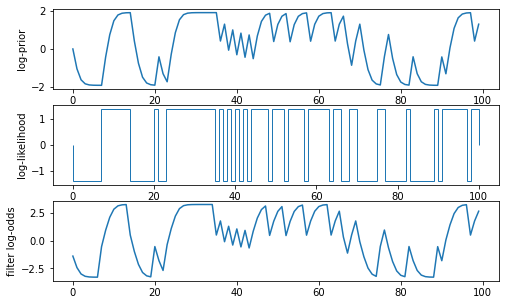

In [81]:
(fig, ax) = plt.subplots(3, 1, figsize=(8, 5))

ax[0].plot(b_prior)
ax[0].set_ylabel('log-prior')

ax[1].stairs(b_lik)
ax[1].set_ylabel('log-likelihood')

ax[2].plot(b_filter)
ax[2].set_ylabel('filter log-odds');

In [87]:
(fig, ax) = plt.subplots(3, 1, figsize=(10, 5))

ax[0].stairs(b_smps)
ax[0].set_ylabel('block')

ax[1].stairs(s_smps)
ax[1].set_ylabel('stimulus side')

ax[2].plot(b_filter)
ax[2].set_ylabel('filter log-odds');

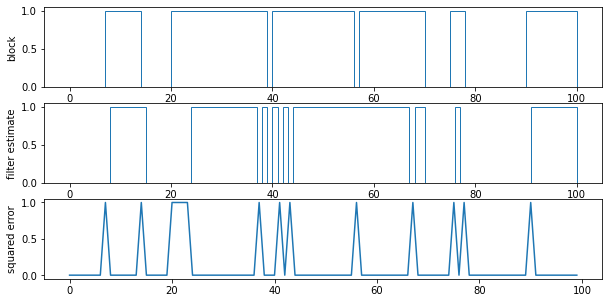

In [90]:
(fig, ax) = plt.subplots(3, 1, figsize=(10, 5))

ax[0].stairs(b_smps)
ax[0].set_ylabel('block')

ax[1].stairs(filter_est)
ax[1].set_ylabel('filter estimate');

ax[2].plot(filter_err)
ax[2].set_ylabel('squared error');